# Mess with VAE embeddings and Unet to get a transition

In this Notebook a previously generated image is used as initial image for the next prompt.  
The results where not promissing, because stable diffusion already removed the noise in the first picture so it could not generate the second image.  
Intrducing new noise fixed this problem, but the initial image had to be so noisy that the transition was meaningless.

### Outlook
If the scheduler is modified to be aware of how much noise is left in the the image the tesults would possibly look different

In [1]:
from PIL import Image
import torch
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler
from diffusers.image_processor import VaeImageProcessor
from utils.model import VAE
from utils.show import flipbook

In [4]:
#load components
tokenizer = CLIPTokenizer.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="text_encoder", use_safetensors=True)
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", use_safetensors=True)
scheduler = PNDMScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")

In [5]:
# move to GPU
device = "cuda"
text_encoder.to(device)
unet.to(device)
vae = VAE()

In [6]:
# config
prompt = ["a picture of a red car", 'a picture of a green airplane']
height = 512
width = 512
num_inference_steps = 25
guidance_scale = 7.5
generator = torch.manual_seed(1)

In [7]:
# generate text tokens and embeddings 
def clip(text):
    text_input = tokenizer(text, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
    with torch.no_grad():
        text_embeddings = text_encoder(text_input.input_ids.to(device))[0]

    # empty embeddings used for classifier free guidance
    max_length = text_input.input_ids.shape[-1]
    uncond_input = tokenizer([""] * len(text), padding="max_length", max_length=max_length, return_tensors="pt")
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(device))[0]
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
    return text_embeddings

In [8]:
def getRnd(size):
    latents = torch.randn((size, unet.config.in_channels, height // 8, width // 8),
        generator=generator,
    )
    latents = latents.to(device)
    latents = latents * scheduler.init_noise_sigma
    return latents

In [9]:
# generate

def gen(start, conditioning, s=num_inference_steps):
    latents = start
    intermediate = torch.zeros([s+1,4,64,64]).to(device)
    scheduler.set_timesteps(s)
    for x,t in enumerate(tqdm(scheduler.timesteps)):
        latent_model_input = torch.cat([latents] *2)
        latent_model_input = scheduler.scale_model_input(latent_model_input, timestep=t)
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=conditioning).sample

        noise_pred_uncond, noise_pred_text =noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
        latents = scheduler.step(noise_pred, t, latents).prev_sample
        intermediate[x] = latents.clone()
    return [latents, intermediate]

# Workflow:

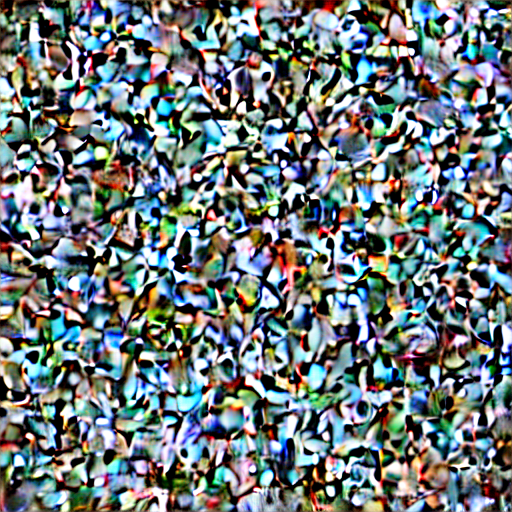

In [10]:
noise = getRnd(1)
flipbook(vae.d(noise))

In [11]:
emb01 = clip(['A green car'])
emb01.shape

torch.Size([2, 77, 768])

In [12]:
l01, steps01 = gen(getRnd(1), emb01, 50)
out01 = vae.d(steps01)

  0%|          | 0/51 [00:00<?, ?it/s]

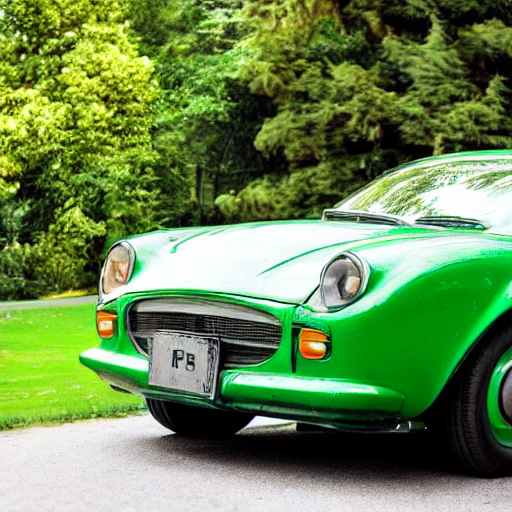

In [13]:
flipbook(out01, 0.2)

In [14]:
ratio = 1/2
l02 = (l01[0]*ratio+getRnd(1)[0]*(1-ratio))
l02 = l02.unsqueeze(0)

In [15]:
out02 = vae.d(l02)

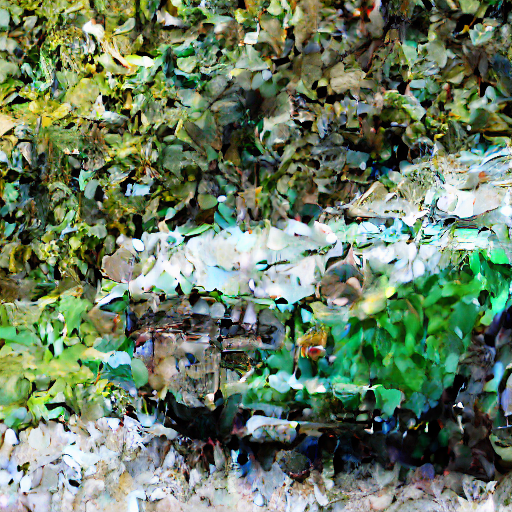

In [16]:
flipbook(out02)

In [17]:
emb02 = clip(['a red airplane plane'])

In [18]:
l03,steps03 = gen(l02, emb02)
#l03,steps03 = gen(l01, emb02)
#l03,steps03 = gen(getRnd(1), emb02)
out03 = vae.d(steps03)

  0%|          | 0/26 [00:00<?, ?it/s]

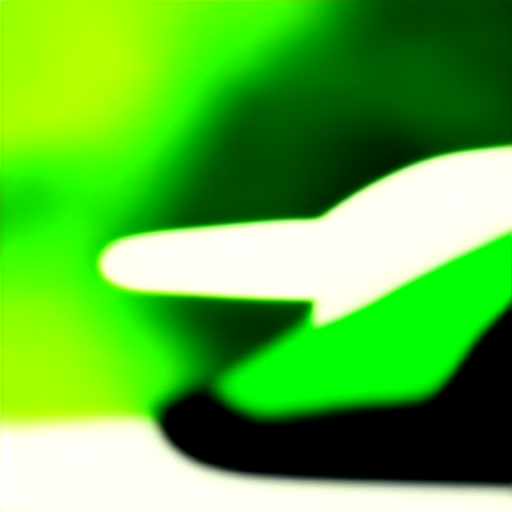

In [19]:
flipbook(out03)